In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib
from skimage.measure import label, regionprops 
from scipy.ndimage import binary_dilation, label as ndi_label
from scipy.ndimage import binary_fill_holes, generate_binary_structure
from skimage.color import label2rgb
from skimage.measure import regionprops, label
import math 
import os 
import csv

Loading Data 

In [69]:
def load_nifti(filepath):
    return nib.load(filepath)

In [101]:
ct_image = load_nifti("3702_left_knee.nii.gz") 
ct_data = ct_image.get_fdata()
spacing = ct_image.header.get_zooms()
print("Shape:", ct_data.shape, "Spacing:", spacing)

Shape: (512, 512, 216) Spacing: (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))


divided part <class 'int'>


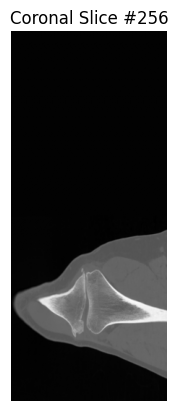

In [102]:

mid_coronal = ct_data.shape[1] // 2
print('divided part', type(mid_coronal))
plt.imshow(ct_data[:, mid_coronal, :], cmap="gray")
plt.title(f"Coronal Slice #{mid_coronal}")
plt.axis('off')
plt.show()

Rotating the Image



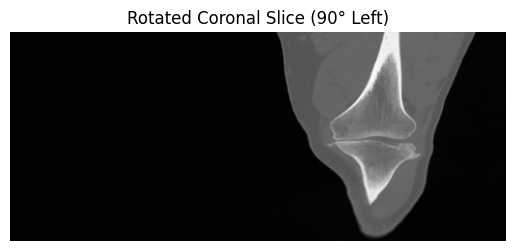

In [100]:
# Normalize and rotate image
slice_img = ct_data[:, mid_coronal, :]
slice_img_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))
slice_rotated = np.rot90(slice_img_norm)  # Rotate 90 degree left
plt.imshow(slice_rotated, cmap='gray')
plt.title("Rotated Coronal Slice (90° Left)")
plt.axis('off')
plt.show()

In [8]:
threshold = 0.5
binary_bone = slice_rotated > threshold
binary_filled = binary_fill_holes(binary_bone.astype(bool))

# Label connected components (using scipy)
labeled, num = ndi_label(binary_filled)
print("Number of connected components:", num)

regions = regionprops(labeled)
regions = sorted(regions, key=lambda x: x.area, reverse=True)

segmented = np.zeros_like(labeled)
if len(regions) >= 2:
    segmented[labeled == regions[0].label] = 1  # Femur
    segmented[labeled == regions[1].label] = 2  # Tibia

Number of connected components: 10


Task 1.1 : Bone Segmentation


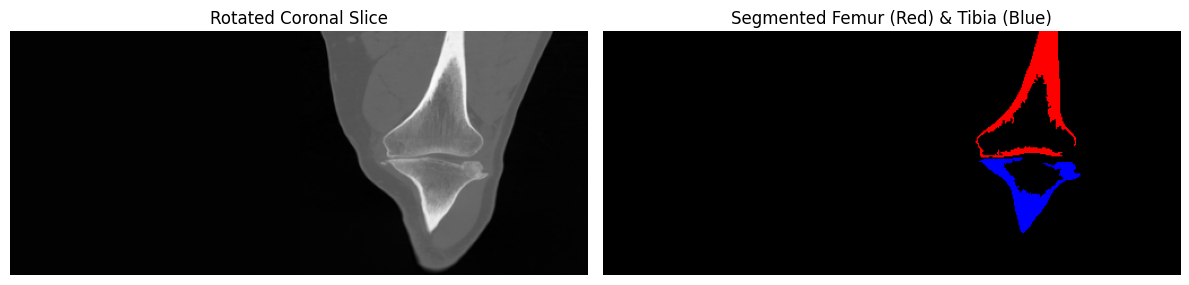

In [9]:
color_segmented = label2rgb(segmented, bg_label=0, colors=['red', 'blue'])  # Femur = red, Tibia = blue

# Show both original rotated slice and segmented result
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(slice_rotated, cmap='gray')
axes[0].set_title("Rotated Coronal Slice")
axes[0].axis('off')

axes[1].imshow(color_segmented)
axes[1].set_title("Segmented Femur (Red) & Tibia (Blue)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Saving the result in .nii.gz


In [10]:
# Convert 2D segmentation to 3D format
segmented_3d = np.zeros_like(ct_data, dtype=np.int16)
segmented_3d[:, mid_coronal, :] = np.rot90(segmented, k=-1)  # Rotate back 90 degree right to match original orientation

segmented_nifti = nib.Nifti1Image(segmented_3d, ct_image.affine, ct_image.header)

output_filename = "3702_left_knee_segmented.nii.gz"
nib.save(segmented_nifti, output_filename)
print(f"Segmentation saved as: {output_filename}")

Segmentation saved as: 3702_left_knee_segmented.nii.gz


Task 1.2 : Contour Expansion 


In [ ]:
pixel_spacing = np.mean([spacing[0], spacing[2]])
pixels_to_expand = int(np.round(2.0 / pixel_spacing))

# Create binary mask from segmented femur and tibia
mask = segmented > 0

# Expand the mask by 2mm using binary dilation
expanded_mask = binary_dilation(mask, iterations=pixels_to_expand)

masked_image = np.where(expanded_mask, slice_rotated, 0)

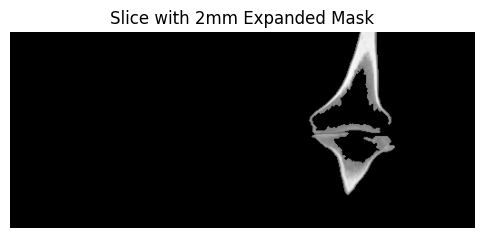

In [26]:
plt.figure(figsize=(6, 6))
plt.imshow(masked_image, cmap='gray')
plt.title("Slice with 2mm Expanded Mask")
plt.axis('off')
plt.show()

Task 1.3 : Randomized Contour Adjustment 

In [45]:
def generate_randomized_mask(original_mask, spacing, max_expansion_mm=2.0, random_fraction=0.5):

    pixel_spacing = np.mean([spacing[0], spacing[2]])
    pixels_to_expand = int(np.round(max_expansion_mm / pixel_spacing))


    expanded_mask = binary_dilation(original_mask, iterations=pixels_to_expand)

    expansion_region = expanded_mask & ~original_mask

    random_mask = np.zeros_like(original_mask, dtype=bool)
    random_mask[expansion_region] = np.random.rand(np.sum(expansion_region)) < random_fraction

    randomized_mask = original_mask | random_mask

    return randomized_mask


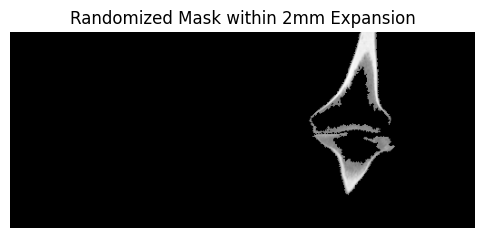

In [46]:
original_mask = segmented > 0

randomized_mask = generate_randomized_mask(original_mask, spacing, max_expansion_mm=2.0, random_fraction=0.5)

masked_random_image = np.where(randomized_mask, slice_rotated, 0)

plt.figure(figsize=(6, 6))
plt.imshow(masked_random_image, cmap='gray')
plt.title("Randomized Mask within 2mm Expansion")
plt.axis('off')
plt.show()


Task 1.4 : Landmark Detection in Tibia 

In [ ]:
def save_mask(mask, reference_nifti, filename):
    mask = mask.astype(np.uint8) 
    new_img = nib.Nifti1Image(mask, affine=reference_nifti.affine, header=reference_nifti.header)
    nib.save(new_img, filename)
    print(f"Saved: {filename}")

In [55]:
def expand_mask(mask_3d, spacing, expansion_mm):
    pixel_spacing = np.mean([spacing[0], spacing[2]]) 
    pixels = int(np.round(expansion_mm / pixel_spacing))
    return binary_dilation(mask_3d, iterations=pixels)

In [47]:
def generate_randomized_mask(original_mask, spacing, max_expansion_mm=2.0, random_fraction=0.5):
    pixel_spacing = np.mean([spacing[0], spacing[2]])
    max_pixels = int(np.round(max_expansion_mm / pixel_spacing))
    
    # Fully expanded mask
    fully_expanded = binary_dilation(original_mask, iterations=max_pixels)
    intermediate_mask = original_mask.copy()

    for _ in range(max_pixels):
        potential = binary_dilation(intermediate_mask) & ~intermediate_mask

        random_mask = np.random.rand(*original_mask.shape) < random_fraction

        expansion = potential & random_mask
        intermediate_mask = intermediate_mask | expansion

    randomized = np.logical_and(intermediate_mask, fully_expanded)
    randomized = np.logical_or(randomized, original_mask)
    return randomized.astype(np.uint8)


In [44]:
unrotated_mask = np.rot90(mask, k=-1) 

mask_3d = np.zeros_like(ct_data, dtype=np.uint8)
mask_3d[:, mid_coronal, :] = unrotated_mask 

original_mask = mask_3d
expanded_2mm = expand_mask(original_mask, spacing, 2.0)
expanded_4mm = expand_mask(original_mask, spacing, 4.0)
random_mask_1 = generate_randomized_mask(original_mask, spacing, max_expansion_mm=2.0, random_fraction=0.4)
random_mask_2 = generate_randomized_mask(original_mask, spacing, max_expansion_mm=2.0, random_fraction=0.8)

save_mask(original_mask, ct_image, "original_mask.nii.gz")
save_mask(expanded_2mm, ct_image, "expanded_2mm_mask.nii.gz")
save_mask(expanded_4mm, ct_image, "expanded_4mm_mask.nii.gz")
save_mask(random_mask_1, ct_image, "randomized_mask_1.nii.gz")
save_mask(random_mask_2, ct_image, "randomized_mask_2.nii.gz")

Saved: original_mask.nii.gz
Saved: expanded_2mm_mask.nii.gz
Saved: expanded_4mm_mask.nii.gz
Saved: randomized_mask_1.nii.gz
Saved: randomized_mask_2.nii.gz


In [ ]:
def find_lowest_points(mask, spacing):
    coords = np.array(np.where(mask > 0)).T  
    if coords.shape[0] == 0:
        return None, None

    x_center = np.median(coords[:, 2])

    medial = coords[coords[:, 2] < x_center]
    lateral = coords[coords[:, 2] >= x_center]

    medial_lowest = medial[np.argmax(medial[:, 1])] if medial.size > 0 else None
    lateral_lowest = lateral[np.argmax(lateral[:, 1])] if lateral.size > 0 else None

    return medial_lowest, lateral_lowest

In [ ]:
def voxel_to_mm(coord, spacing):
    if coord is None:
        return None
    z, y, x = coord
    return (x * spacing[2], y * spacing[1], z * spacing[0])  #In mm


In [61]:
def load_and_process_mask(mask_path, spacing):
    mask_nifti = nib.load(mask_path)
    mask_data = mask_nifti.get_fdata()
    mask_data = (mask_data > 0).astype(np.uint8)
    return find_lowest_points(mask_data, spacing)

In [62]:
mask_paths = [
    "original_mask.nii.gz",
    "expanded_2mm_mask.nii.gz",
    "expanded_4mm_mask.nii.gz",
    "randomized_mask_1.nii.gz",
    "randomized_mask_2.nii.gz",
]

mask_labels = [
    "Original",
    "Expanded 2mm",
    "Expanded 4mm",
    "Randomized 40%",
    "Randomized 80%"
]

In [ ]:
spacing = (0.5, 0.5, 0.5)  

rows = []
header = [
    "Mask Name",
    "Medial Voxel (z,y,x)",
    "Medial Coord (x,y,z mm)",
    "Lateral Voxel (z,y,x)",
    "Lateral Coord (x,y,z mm)"
]


In [64]:
for label, path in zip(mask_labels, mask_paths):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    medial_voxel, lateral_voxel = load_and_process_mask(path, spacing)
    medial_mm = voxel_to_mm(medial_voxel, spacing)
    lateral_mm = voxel_to_mm(lateral_voxel, spacing)

    rows.append([
        label,
        str(tuple(medial_voxel)) if medial_voxel is not None else "Not found",
        str(medial_mm) if medial_mm is not None else "Not found",
        str(tuple(lateral_voxel)) if lateral_voxel is not None else "Not found",
        str(lateral_mm) if lateral_mm is not None else "Not found",
    ])


In [67]:
with open("tibial_lowest_points.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print("CSV file 'tibial_lowest_points.csv' created successfully.")

CSV file 'tibial_lowest_points.csv' created successfully.
